In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns


# Combine all CSV files into a single DataFrame

/tmp/ipykernel_488/3091987745.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


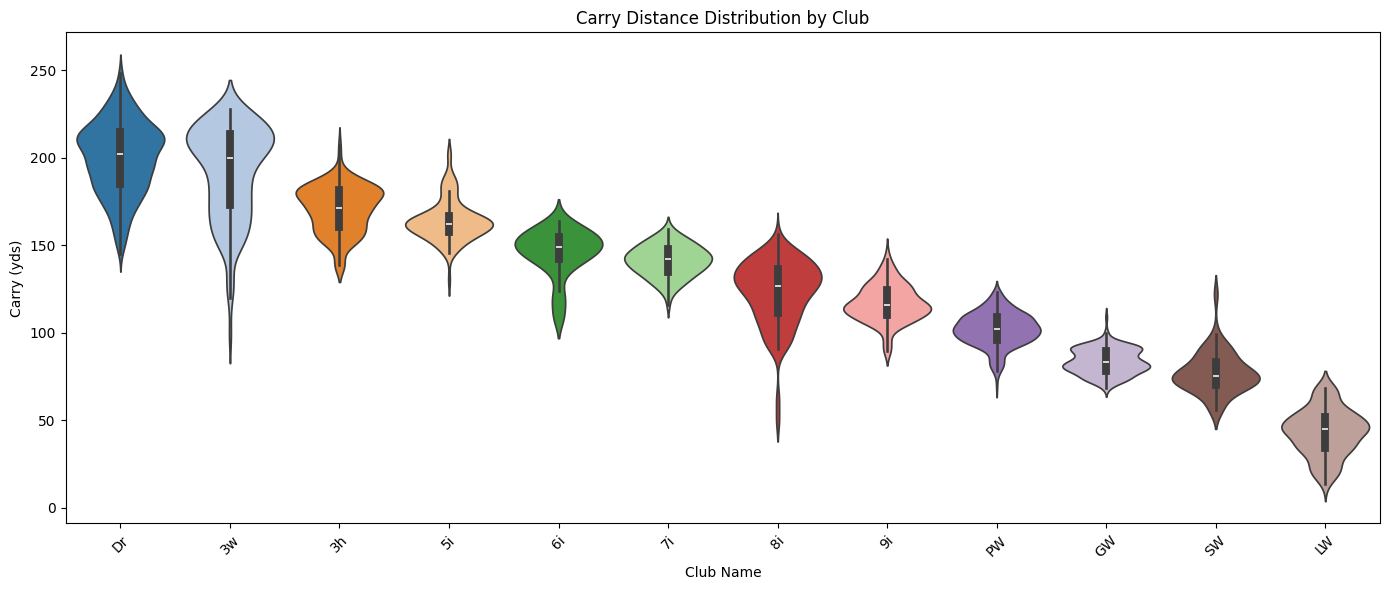

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load all CSVs from sessions folder
directory_path = './sessions'
dataframes = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        dataframes.append(pd.read_csv(file_path))

# Step 2: Combine all files
combined_df = pd.concat(dataframes, ignore_index=True)

# Step 3: Normalize and optimize club names
combined_df['Club Name'] = combined_df['Club Name'].astype(str).str.strip().str.lower()

club_name_map = {
    'driver': 'Dr', 'dr': 'Dr',
    '3 wood': '3w', '3w': '3w',
    '5 wood': '5w', '5w': '5w',
    '3 hybrid': '3h', '3h': '3h',
    '4 hybrid': '4h', '4h': '4h',
    '3 iron': '3i', '3i': '3i',
    '4 iron': '4i', '4i': '4i',
    '5 iron': '5i', '5i': '5i',
    '6 iron': '6i', '6i': '6i',
    '7 iron': '7i', '7i': '7i',
    '8 iron': '8i', '8i': '8i',
    '9 iron': '9i', '9i': '9i',
    'pitching wedge': 'PW', 'pw': 'PW',
    'gap wedge': 'GW', 'gw': 'GW',
    'sand wedge': 'SW', 'sw': 'SW',
    'lob wedge': 'LW', 'lw': 'LW',
    'wedge': 'SW', 'swedge': 'SW'  # catch-all for generic "wedge"
}
combined_df['Club Name'] = combined_df['Club Name'].map(club_name_map).fillna('Other')

# Step 4: Filter to valid club list only
valid_clubs = ['Dr', '3w', '3h', '5i', '6i', '7i', '8i', '9i', 'PW', 'GW', 'SW', 'LW']
combined_df = combined_df[combined_df['Club Name'].isin(valid_clubs)]

# Step 5: Violin plot of carry distance by club
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=combined_df,
    x='Club Name',
    y='Carry (yds)',
    order=valid_clubs,
    palette='tab20',
    inner='box'
)
plt.xticks(rotation=45)
plt.title('Carry Distance Distribution by Club')
plt.tight_layout()
plt.show()
combined_df.to_csv('all_shots_gulftee.csv')


Filling in missing values in Club Speed (mph) and Club Speed at Impact Location (mph)

In [ ]:
import pandas as pd
data = pd.read_csv('all_shots_gulftee.csv',index_col=0)

In [ ]:
club_lofts = {
    'Dr': 10.5,
    '3w': 15,
    '5w': 19,
    '3h': 19,
    '4h': 22,
    '5h': 25,
    '3i': 21,
    '4i': 24,
    '5i': 27,
    '6i': 31,
    '7i': 35,
    '8i': 39,
    '9i': 43,
    'PW': 47
}

# Function to get the loft for each club
def get_club_loft(club_name):
    return club_lofts.get(club_name, None)

# Apply the function to get the loft for each club
data['Loft (deg)'] = data['Club Name'].apply(get_club_loft)


# Estimate Club Speed (mph)
def estimate_club_speed(row):
    if pd.isnull(row['Club Speed (mph)']):
        if 'Driver' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.55 # Assuming average smash factor of 1.45 for driver
        elif 'Iron' in row['Club Type']:
            return row['Ball Speed (mph)']  / 1.25
        elif 'Hybrid' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.35
        elif 'FW' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.45

    return row['Club Speed (mph)']

# Estimate Club Speed at Impact Location (mph)
def estimate_club_speed_impact(row):
    if pd.isnull(row['Club Speed at Impact Location (mph)']):
        return row['Club Speed (mph)'] * 0.98  # Assuming a slight reduction for off-center hits
    return row['Club Speed at Impact Location (mph)']

# Calculate Efficiency
def calculate_efficiency(row):
    if pd.isnull(row['Efficiency']):
        if 'Driver' in row['Club Type']:
            return row['Efficiency'] / 1.55 # Assuming average smash factor of 1.45 for driver
        elif 'Iron' in row['Club Type']:
            return row['Efficiency']  / 1.25
        elif 'Hybrid' in row['Club Type']:
            return row['Efficiency'] / 1.35
        elif 'FW' in row['Club Type']:
            return row['Efficiency'] / 1.45

    return row['Efficiency']

# Estimate Angle of Attack (deg)
#def estimate_angle_of_attack(row):
#    if pd.isnull(row['Angle of Attack (deg)']):
#        if 'Driver' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 12  # Adjust to fit the +1 to +5 range
#        elif 'Iron' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 5  # Adjust to fit the -3 to -6 range
#        elif 'Hybrid' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 5  # Adjust to fit the -2 to +2 range
#        elif 'FW' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 7  # Adjust to fit the -1 to +3 range
#    return row['Angle of Attack (deg)']

# Estimate Club Path (deg out-in-/in-out+)
def estimate_club_path(row):
    if pd.isnull(row['Club Path (deg out-in-/in-out+)']):
        return row['Push/Pull (deg L-/R+)'] * 1.2  # Assuming a relationship between path and face angle
    return row['Club Path (deg out-in-/in-out+)']

# Estimate Face to Target (deg closed-/open+)
def estimate_face_to_target(row):
    if pd.isnull(row['Face to Target (deg closed-/open+)']):
        return row['Push/Pull (deg L-/R+)']
    return row['Face to Target (deg closed-/open+)']

# Estimate Lie (deg toe down-/toe up+)
def estimate_lie(row):
    if pd.isnull(row['Lie (deg toe down-/toe up+)']):
        return 0  # Default to 0 if no data available
    return row['Lie (deg toe down-/toe up+)']

# Loft (deg) is already present in the data

# Estimate Face Impact Horizontal (mm toe-/heel+)
def estimate_face_impact_horizontal(row):
    if pd.isnull(row['Face Impact Horizontal (mm toe-/heel+)']):
        return 0  # Default if no data available
    return row['Face Impact Horizontal (mm toe-/heel+)']

# Estimate Face Impact Vertical (mm low-/high+)
def estimate_face_impact_vertical(row):
    if pd.isnull(row['Face Impact Vertical (mm low-/high+)']):
        return 0  # Default if no data available
    return row['Face Impact Vertical (mm low-/high+)']

# Estimate Closure Rate (deg/sec)
def estimate_closure_rate(row):
    if pd.isnull(row['Closure Rate (deg/sec)']):
        return 0  # Default if no data available
    return row['Closure Rate (deg/sec)']

# Apply functions to calculate missing metrics
data['Club Speed (mph)'] = data.apply(estimate_club_speed, axis=1)
data['Club Speed at Impact Location (mph)'] = data.apply(estimate_club_speed_impact, axis=1)
data['Efficiency'] = data.apply(calculate_efficiency, axis=1)
#data['Angle of Attack (deg)'] = data.apply(estimate_angle_of_attack, axis=1)
data['Club Path (deg out-in-/in-out+)'] = data.apply(estimate_club_path, axis=1)
data['Face to Target (deg closed-/open+)'] = data.apply(estimate_face_to_target, axis=1)
data['Lie (deg toe down-/toe up+)'] = data.apply(estimate_lie, axis=1)
data['Face Impact Horizontal (mm toe-/heel+)'] = data.apply(estimate_face_impact_horizontal, axis=1)
data['Face Impact Vertical (mm low-/high+)'] = data.apply(estimate_face_impact_vertical, axis=1)
data['Closure Rate (deg/sec)'] = data.apply(estimate_closure_rate, axis=1)



In [ ]:
data['Club Name'] = data['Club Name'].replace({'5i': '5h', '4i': '4h'})

<Axes: xlabel='Club Type', ylabel='Side Spin (rpm L-/R+)'>

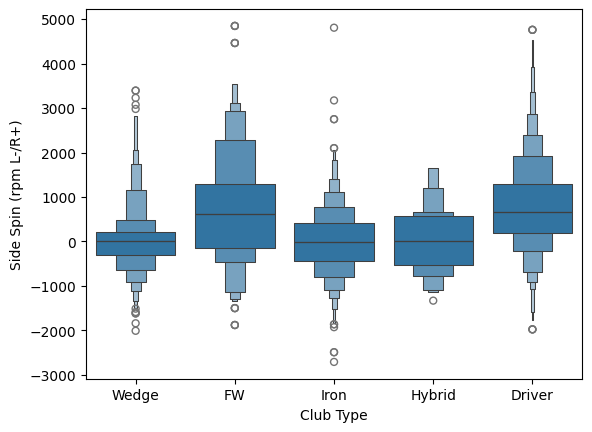

In [ ]:
sns.boxenplot(data=data,x='Club Type',y='Side Spin (rpm L-/R+)')

/tmp/ipykernel_488/1628060441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Club Name', y='Carry (yds)', data=data, palette='Set1',fill=False)
/tmp/ipykernel_488/1628060441.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Club Name', y='Carry (yds)', data=data, palette='Set1', alpha=0.5, linewidth=0.5)


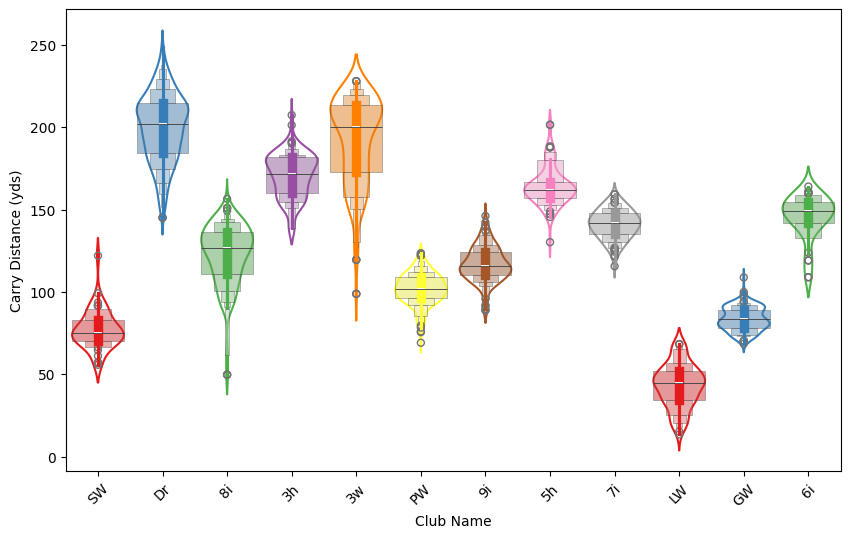

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize carry distance distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='Club Name', y='Carry (yds)', data=data, palette='Set1',fill=False)
sns.boxenplot(x='Club Name', y='Carry (yds)', data=data, palette='Set1', alpha=0.5, linewidth=0.5)
plt.title = 'Carry Distance Distribution by Club'
plt.xlabel('Club Name')
plt.ylabel('Carry Distance (yds)')
plt.xticks(rotation=45)
plt.show()


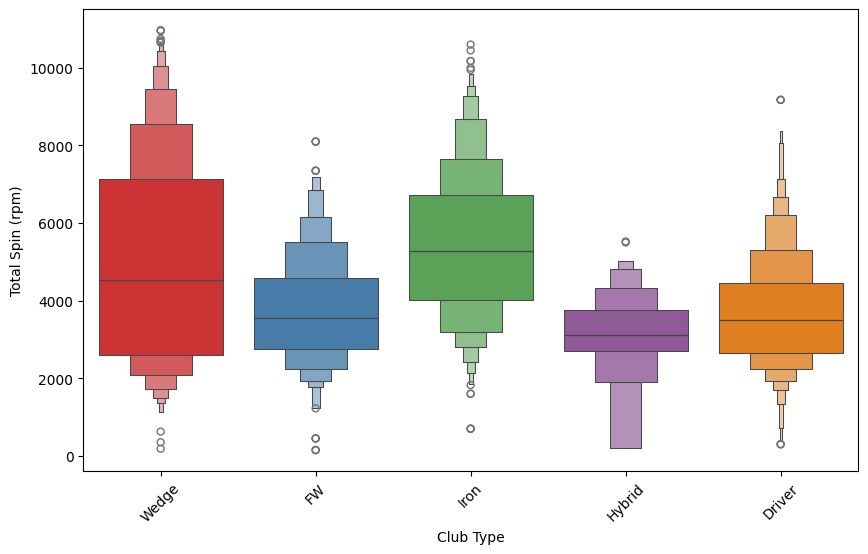

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Club Type', y='Total Spin (rpm)', data=data, palette='Set1', hue='Club Type',legend=False)
plt.title= ('Total Spin (rpm) Distribution by Club')
plt.xlabel('Club Type')
plt.ylabel('Total Spin (rpm)')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_488/2257589242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Club Name', y='Push/Pull (deg L-/R+)', data=data, palette="Set1")


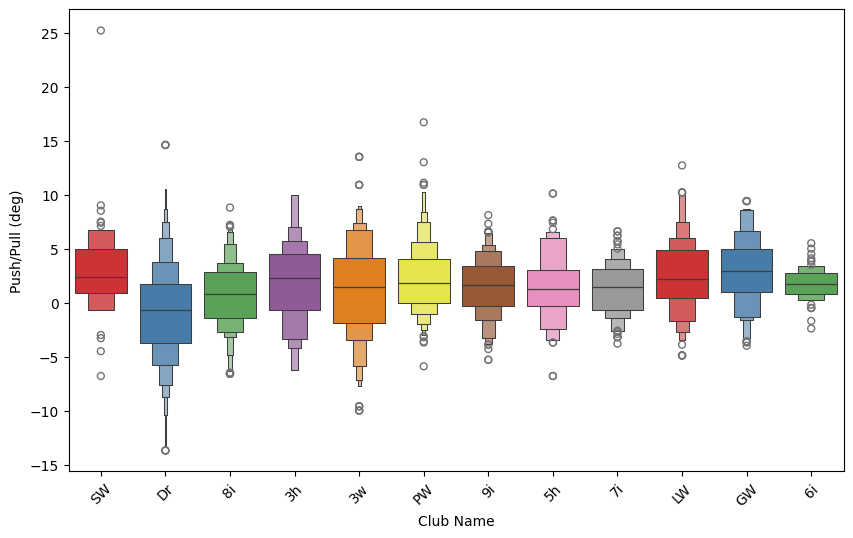

In [ ]:
# Visualize accuracy (Push/Pull) distribution
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Club Name', y='Push/Pull (deg L-/R+)', data=data, palette="Set1")
plt.title = ('Push/Pull Distribution by Club')
plt.xlabel('Club Name')
plt.ylabel('Push/Pull (deg)')
plt.xticks(rotation=45)
plt.show()


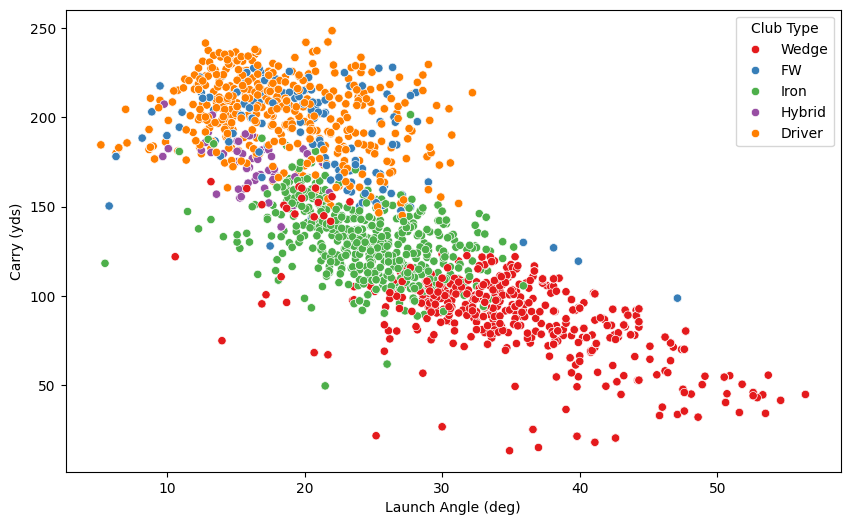

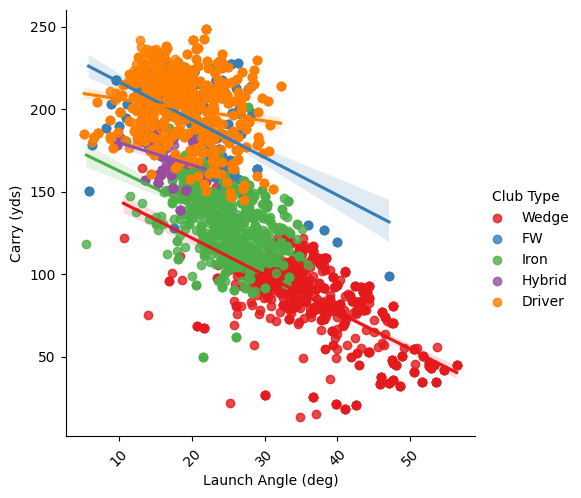

In [ ]:
# Visualize launch angle and Carry
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Launch Angle (deg)', y='Carry (yds)',hue = 'Club Type' ,data=data, palette='Set1')
plt.title='Launch Angle and Carry relationship'
sns.lmplot(x='Launch Angle (deg)', y='Carry (yds)', data=data, hue='Club Type', palette='Set1')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# prompt: sort the club avg distances from low to high then plot ball speed distribution by club boxenplots

import matplotlib.pyplot as plt
# Calculate average carry distance per club and sort
avg_carry_by_club = combined_df.groupby('Club Name')['Carry (yds)'].mean().sort_values()

# Get the sorted list of clubs
sorted_clubs = avg_carry_by_club.index.tolist()

# Plot Ball Speed distribution by club using boxenplots, sorted by average carry distance
plt.figure(figsize=(14, 6))
sns.boxenplot(
    data=combined_df,
    x='Club Name',
    y='Ball Speed (mph)',
    order=sorted_clubs,
    palette='tab20'
)
plt.xticks(rotation=45)
plt.title('Ball Speed Distribution by Club (Sorted by Average Carry Distance)')
plt.ylabel('Ball Speed (mph)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_488/1853431520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Club Name', y='Ball Speed (mph)', data=data, palette='Set1', alpha=0.5)
/tmp/ipykernel_488/1853431520.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Club Name', y='Ball Speed (mph)', data=data,  palette='Set1', fill=False)


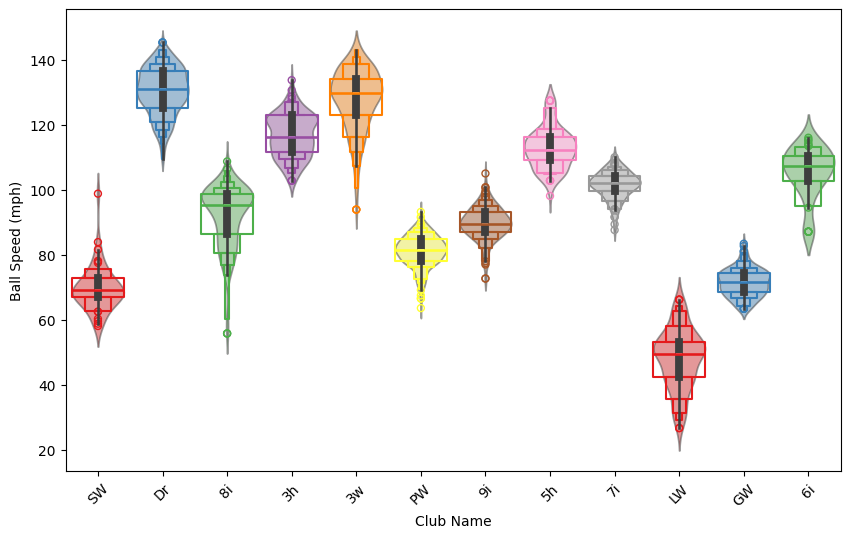

In [ ]:
# Visualize accuracy (Push/Pull) distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='Club Name', y='Ball Speed (mph)', data=data, palette='Set1', alpha=0.5)
sns.boxenplot(x='Club Name', y='Ball Speed (mph)', data=data,  palette='Set1', fill=False)
plt.title = ('Ball Speed (mph) Distribution by Club')
plt.xlabel('Club Name')
plt.ylabel('Ball Speed (mph)')
plt.xticks(rotation=45)
plt.show()


TypeError: 'str' object is not callable

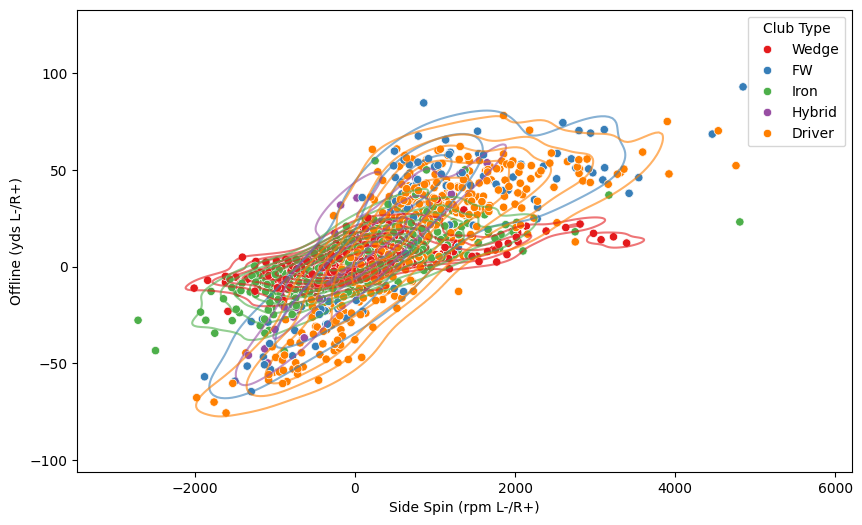

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='Side Spin (rpm L-/R+)', y='Offline (yds L-/R+)', data=data,palette='Set1', hue='Club Type', alpha=0.6)
sns.scatterplot(x='Side Spin (rpm L-/R+)', y='Offline (yds L-/R+)', data=data,legend=True, hue='Club Type', palette='Set1')
plt.title('Side Spin relation to Offline')
plt.xlabel('Side Spin (rpm L-/R+)')
plt.ylabel('Offline (yds L-/R+)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate efficiency (smash factor) summary
efficiency_summary = data.groupby('Club Name').agg({
    'Club Speed (mph)': ['mean', 'std'],
    'Ball Speed (mph)': ['mean', 'std'],
    'Carry (yds)': ['mean', 'std'],
    'Launch Angle (deg)': ['mean', 'std']

}).reset_index()

# Flatten the multi-level columns
efficiency_summary.columns = ['Club Name','Club Speed Mean', 'Club Speed Std',
                              'Ball Speed Mean', 'Ball Speed Std', 'Carry Mean',
                              'Carry Std','Launch Angle Mean', 'Launch Angle Std']
efficiency_summary
#efficiency_summary.to_csv("Metrics/Std_Mean_by_Club.csv",index=False)


,Club Name,Club Speed Mean,Club Speed Std,Ball Speed Mean,Ball Speed Std,Carry Mean,Carry Std,Launch Angle Mean,Launch Angle Std
0,3h,86.075838,4.754762,116.202381,6.418929,169.069048,13.115823,16.747619,3.113766
1,3w,88.098746,6.650316,127.743182,9.642958,191.768182,26.956434,20.638636,6.130143
2,4h,87.663055,8.826220,117.124719,10.717853,170.874157,22.969676,18.046067,5.309624
3,5h,86.922080,7.002299,116.000000,8.338486,172.343434,18.666315,20.216162,4.809143
4,5w,87.969186,4.776523,127.555319,6.925959,190.073404,18.760860,21.176596,5.365575
5,6i,69.760000,0.000000,87.200000,0.000000,114.000000,5.888973,22.100000,4.618802
6,8i,62.891429,6.333473,78.614286,7.916841,97.390476,15.665930,27.095238,3.775722
7,Dr,83.747142,5.091608,129.808070,7.891993,197.622456,21.286663,20.693684,4.925158


In [ ]:
data['Spin Efficiency'] = (data['Back Spin (rpm)'] + data['Side Spin (rpm L-/R+)']) / data['Ball Speed (mph)']

In [ ]:
data['Spin Efficiency']

0       32.898032
1       36.803045
2       52.987478
3       40.756664
4       48.145695
          ...    
1523    22.276423
1524    26.878762
1525    23.516020
1526    47.826476
1527    28.894309
Name: Spin Efficiency, Length: 1528, dtype: float64

In [ ]:
# Save the updated DataFrame to a new CSV file
updated_file_path = 'updated_metrics_gulftee.csv'  # Update this path
data.to_csv(updated_file_path, index=False)
print(f"Updated CSV saved to {updated_file_path}")

Updated CSV saved to updated_metrics_gulftee.csv


## Train a model to predict club-path


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
url = "https://raw.githubusercontent.com/tim-blackmore/launch-monitor-regression/main/data.csv"
df = pd.read_csv(url)




In [23]:
def clean_numeric_column(series):
    """Cleans unit-labeled strings and converts to float, returns unchanged if can't clean."""
    try:
        # Remove units and symbols
        cleaned = (
            series.astype(str)
            .str.replace(r'[^0-9.\-]', '', regex=True)  # Keep numbers, decimal, minus
            .replace('', pd.NA)
        )
        return pd.to_numeric(cleaned, errors='coerce')
    except Exception as e:
        return series  # Return original if cleaning not possible

# Apply only to object columns that are numeric-like
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(r'\d', regex=True).any():
        df[col] = clean_numeric_column(df[col])




In [32]:
features = [
    'Ball Speed', 'Club Speed', 'Launch Angle', 'Spin Rate', 'Smash Factor',
    'Attack Angle', 'Face Angle', 'Dyn. Loft', 'Swing Direction', 'Curve'
]
targets = ['Club Path', 'Face To Path']

df_clean = df.dropna(subset=features + targets)
X = df_clean[features]
y = df_clean[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
for i, target in enumerate(targets):
    print(f"=== {target.upper()} ===")
    print("R² Score:", r2_score(y_test.iloc[:, i], y_pred[:, i]))
    print("MSE:", mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print()


=== CLUB PATH ===
R² Score: 0.9814366561614905
MSE: 0.3798164451903769

=== FACE TO PATH ===
R² Score: 0.9696128793686017
MSE: 1.3260083765547825



In [36]:
df_clean[['Launch Direction', 'Swing Direction']]

,Launch Direction,Swing Direction
1,-2.319,3.089
2,0.846,2.356
5,-6.778,1.003
6,-7.404,0.249
7,-3.841,-1.382
...,...,...
10164,-3.090,-1.403
10165,-0.096,0.383
10166,-1.642,-0.645
10168,-1.586,-3.946


In [33]:
X_train

,Ball Speed,Club Speed,Launch Angle,Spin Rate,Smash Factor,Attack Angle,Face Angle,Dyn. Loft,Swing Direction,Curve
6041,133.336167,97.827935,16.517,4340.0,1.3630,1.162,12.950,19.387,4.001,62.311495
8375,160.596591,109.272101,17.572,2760.0,1.4697,7.300,-1.089,18.944,6.338,-52.627270
1656,155.672870,107.214119,14.431,2710.0,1.4520,1.637,0.305,16.182,2.507,-11.611411
7226,151.264093,103.456067,12.363,2550.0,1.4621,1.700,2.095,14.053,2.467,-6.951912
6962,151.710362,103.979510,11.964,2270.0,1.4590,3.625,2.082,13.436,7.182,-53.508149
...,...,...,...,...,...,...,...,...,...,...
6932,92.667099,71.172602,20.369,4180.0,1.3020,-4.224,2.737,24.842,-4.829,18.656749
6290,104.357999,77.731299,21.419,4220.0,1.3426,-2.619,6.291,25.486,3.231,9.457805
6537,111.797155,83.372853,19.835,4130.0,1.3409,-4.495,3.632,23.554,1.217,-6.282221
1003,168.597441,115.284986,11.113,2790.0,1.4625,-1.115,4.380,12.773,2.244,35.554877


In [6]:
df.columns

Index(['Club', 'Ball', 'Club Speed', 'Attack Angle', 'Club Path', 'Low Point',
       'Swing Plane', 'Swing Direction', 'Dyn. Loft', 'Face Angle',
       'Face To Path', 'Ball Speed', 'Smash Factor', 'Launch Angle',
       'Launch Direction', 'Spin Rate', 'Spin Axis', 'Max Height - Dist.',
       'Max Height - Height', 'Max Height - Side', 'Last data Point - Length',
       'Last data Point - Side', 'Last data Point - Height',
       'Last data Point - Time', 'Carry Flat - Length', 'Carry Flat - Side',
       'Carry Flat - Land. Angle', 'Carry Flat - Ball Speed',
       'Carry Flat - Time', 'Total', 'Side Total', 'Dynamic Lie',
       'Impact Offset', 'Impact Height', 'Curve'],
      dtype='object')